In [1]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

features = [
  'delivery_type', 'total_size', 'distance', 
  'lat', 'long', 'task_around', 
  'city', 'cost', #'total_task',
  
  'pickup_effective_dt', 'delivery_dt',
]
stad_cols = [
  'total_size', 'distance',
  'task_around', 'cost', 'lat', 'long'
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 2408
RESULTS = './results.csv'

In [2]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def cal_total_task():
  delta_times = (df['delivery_effective'] - df['delivery_dt']).dt.total_seconds() / 3600
  dailyDeliveries = pd.to_datetime(df['pickup_effective_dt']).dt.floor('d').value_counts()

def getDailyDeliveriesByDate(date):
    return dailyDeliveries[pd.to_datetime(date).floor('d')]

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

def evaluate(y_test, y_pred, dataframe, threshold=1, save=False):
  pred_bool = np.where(dataframe['pred'] > dataframe['delivery_dt'], True, False)
  test_bool = np.where(dataframe['delivery_effective'] > dataframe['delivery_dt'], True, False)
  f1_pres = f1_score(test_bool, pred_bool)

  delta_pred_bool = (dataframe['pred'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_pred_bool = np.where(delta_pred_bool > threshold, True, False)
  delta_test_bool = (dataframe['delivery_effective'] - dataframe['delivery_dt']).dt.total_seconds() / 3600
  delta_test_bool = np.where(delta_test_bool > threshold, True, False)

  f1_delta = f1_score(delta_pred_bool, delta_test_bool)  
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)

  dataframe['sla_d0'] = pd.to_datetime(dataframe['pickup_effective_dt'].apply(lambda row: row.strftime('%Y-%m-%d 23:59:59+00:00')))
  dataframe['sla_d0'] = dataframe['sla_d0'].dt.tz_localize(None)
  dataframe['sla_d1'] = dataframe['sla_d0'] + pd.DateOffset(days=1)
  dataframe['sla_d1'] = dataframe['sla_d1'].dt.tz_localize(None)

  delta_pred_bool = dataframe['sla_d0'] > dataframe['pred']
  delta_pred_bool = np.where(delta_pred_bool == True, True, False)
  delta_test_bool = dataframe['sla_d0'] > dataframe['delivery_effective']
  delta_test_bool = np.where(delta_test_bool == True, True, False)
  f1_delta_sla_d0 = f1_score(delta_pred_bool, delta_test_bool)
  recall_sla_d0 = recall_score(delta_pred_bool, delta_test_bool)
  precision_score_d0 = precision_score(delta_pred_bool, delta_test_bool)

  delta_pred_bool = dataframe['sla_d1'] > dataframe['pred']
  delta_pred_bool = np.where(delta_pred_bool == True, True, False)
  delta_test_bool = dataframe['sla_d1'] > dataframe['delivery_effective']
  delta_test_bool = np.where(delta_test_bool == True, True, False)
  f1_delta_sla_d1 = f1_score(delta_pred_bool, delta_test_bool)
  recall_sla_d1 = recall_score(delta_pred_bool, delta_test_bool)
  precision_score_d1 = precision_score(delta_pred_bool, delta_test_bool)

  if save:
    save_params({
      'threshold'  : threshold,
      'features'    : features,
      'stad_cols'   : scaler.get_params(deep=True),
      'stad_cols_2' : scaler_2.get_params(deep=True),
      'stad_dates'  : scaler_3.get_params(deep=True)
    },{
      'MAE' : mae,
      'MAPE': mape,
      'RMSE': rmse,
      'R2'  : r2,
      'f1_pres' : f1_pres,
      'f1_delta'  : f1_delta,
      'f1_sla_d0': f1_delta_sla_d0,
      'f1_sla_d1': f1_delta_sla_d1,
    })
  print(
    '{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}\n{10:10s}: {11}\n\nSLA F1:\n{12:10s}: {13}\n{14:10s}: {15}'.format(
    'MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (press)', f1_pres, f'f1 (D {threshold})', f1_delta, 'SLA D0', f1_delta_sla_d0, 'SLA D1', f1_delta_sla_d1
  ))

def remove_outlayers(dataframe: pd.DataFrame, feature: str, complete=False, limit=3, mask=False):
  z_scores = stats.zscore(dataframe[feature])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = abs_z_scores < limit
  if mask:
    return filtered_entries
  if complete:
    return dataframe[filtered_entries]
  return dataframe[ filtered_entries ][feature]

In [10]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')

delta = ((df.delivery_effective - df.delivery_dt).dt.total_seconds() / 3600).abs()

df = df[ delta < 72 ]

# revisar convercion a timestamp de estas 3 columns
df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9



df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])
save_df = False
if save_df:
  df.to_csv('../data/shippify_vertex_std_2.csv', index=False)

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25, random_state=2408)

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

threshold = 1
# Restore scale and type columns
X_test['pred'] = y_pred * 1e9
X_test['delivery_effective'] = y_test * 1e9
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9

X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')
X_test.pickup_effective_dt = X_test.pickup_effective_dt.astype('datetime64[ns]')

# Calculate delta
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds() / 3600
evaluate(y_test, y_pred, X_test, threshold, False)

0.9999234538878466
MAE       : 9816.105107355814
MAPE      : 6.155649929960717e-06
RMSE      : 19957.482066376506
r2        : 0.9999250632322146
f1 (press): 0.8946012972148034
f1 (D 1)  : 0.8337107821475916

SLA F1:
SLA D0    : 0.9064392018849354
SLA D1    : 0.9963601413226303


Aqui presetamos algunas metricas que explicaremos a continuacion:
- f1 (press): metrica calculada dodne un positivo es el hecho de que la fecha de entrega sea mayor que la fecha fijada en el sistema.
- f1 (D): metrica calculada dodne un positivo es el hecho de que la dieferencia de la fehca de entrega sea mayor a un DELTA previamente establecido
- f1 (SLA D0): metrica calculada donde un positivo es el hecho de que una entrega no llegue el mismo dia de la fecha fijada en el sistema.
- f1 (SLA D1): metrica calculada donde un positivo es el hecho de que una entrega no llegue hasta dos dias despues de la fecha establecida en el sistema.

Como podemos ver en la metrica `f1 (press)` el modelo tiene un 0.88 de probabilidad de que la fecha de entrega sea mayor que la fecha fijada en el sistema. Reflejando un modelo con un buen rendimiento.

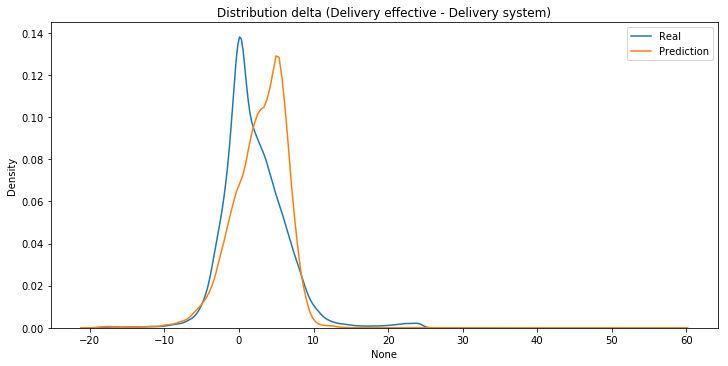

In [5]:
X_test['delta_real'] = (X_test.delivery_effective - X_test.delivery_dt).dt.total_seconds() / 3600

X_test_ = X_test[ remove_outlayers(X_test, 'delta_real', mask=True) ]
delta_real = (X_test_.delivery_effective - X_test_.delivery_dt).dt.total_seconds() / 3600
delta_pred = (X_test_.pred - X_test_.delivery_dt).dt.total_seconds() / 3600
# plot line form list of number
plt.figure(figsize=(10, 5))
plt.title('Distribution delta (Delivery effective - Delivery system)')
plt.tight_layout()
sns.kdeplot(delta_real, label='Real')
sns.kdeplot(delta_pred, label='Prediction')
plt.legend()
plt.savefig('../img/shippify_delta_real_pred.png')

Podemos observar que nuestro modelo suele a marcar a las entregas un poco mas atrasadas que loq ue podrian estar en realidad, sin embargo el modelo sigue la tendencia real de delta real de las entregas.

In [11]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(
  base_score=0.5, booster='gbtree', colsample_bylevel=1,
  colsample_bynode=1, colsample_bytree=1, gamma=0,
  importance_type='gain', learning_rate=0.1, max_delta_step=0,
  max_depth=3, min_child_weight=1, missing=1, n_estimators=100,
  n_jobs=4, nthread=4, objective='reg:squarederror', random_state=42,
  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
  silent=None, subsample=1, verbosity=0
)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=1,
             monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [9]:
score = xgbr.score(X_train, y_train)
score

0.9990720931677816